# Mandatory 1

## Excersise 1

Generate our own dataset for the Franke Function, with $x,y\in[0,1]$

Write our own code to perform a standard least square regression analysis usning polynomials in x and y up to fith order.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from scipy.stats import norm


np.random.seed(np.random.randint(1,1000))

In [6]:
def FrankeFunction(x, y, noise = 0):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + noise * np.random.normal(0,1)

def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)   # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

def least_square(x_value,y_value):
    # Using pinv
    return np.linalg.pinv(x_value.transpose().dot(x_value)).dot(x_value.transpose().dot(y_value))

def plot_errors(x_range_train, x_range_test, y_values_train, y_values_test, title, xlabel_axis, ylabel_axis, graph_label_train, graph_label_test):
    fig = plt.figure(figsize = (20,5))
    plt.xlabel(xlabel_axis)
    plt.ylabel(ylabel_axis)
    plt.title(title)
    plt.plot(x_range_train, y_values_train, label=graph_label_train)
    plt.plot(x_range_test, y_values_test, label=graph_label_test)
    plt.legend()
    plt.show()


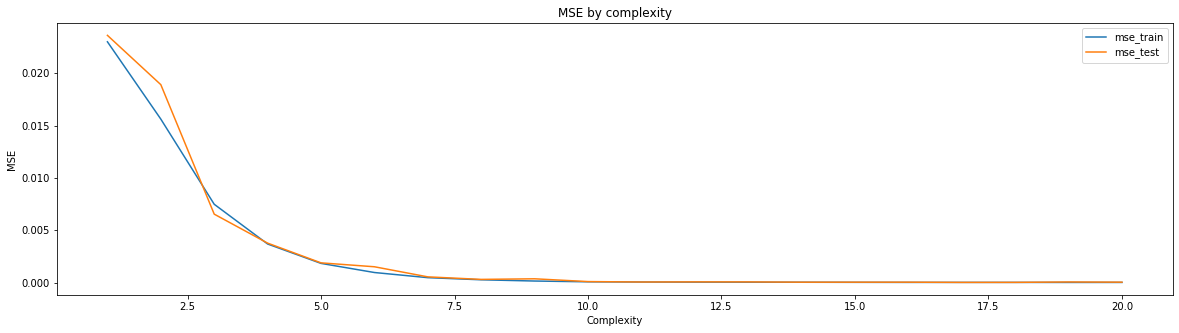

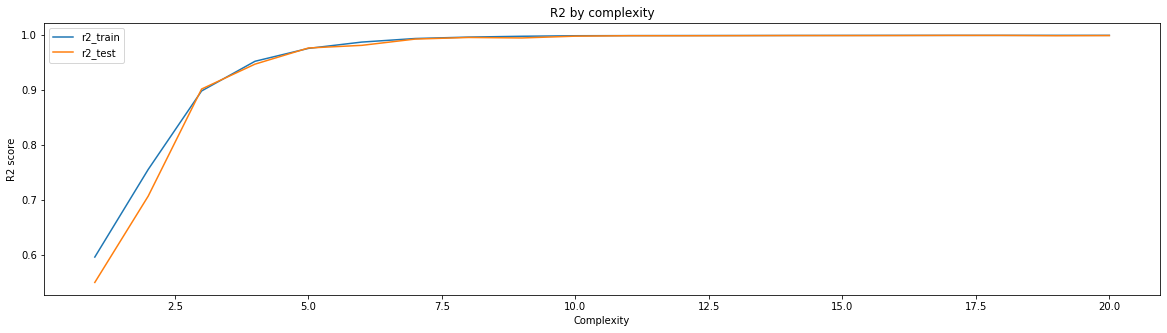

In [47]:
def simple_ols_run(
    x = (np.random.uniform(0, 1, 1000)), 
    y =  (np.random.uniform(0, 1, 1000)), 
    num_points = 1000, 
    complexity = 5, 
    noise = 0, 
    scale = True, 
    plot_mse = False, 
    plot_r2 = False):
    """
    Computes the simples ordinary least square based on the Franke Function
    
    Args:
        stuff
        
    Returns:
        ols_beta: The OLS
    """
    
    if num_points != len(x):
        x = (np.random.uniform(0, 1, num_points))
        y =  (np.random.uniform(0, 1, num_points))
        
        
    MSE_train = []
    MSE_pred = []
    r2_train = []
    r2_pred = []
    
    all_ols_betas = []
    all_xtx_inv = []

    for n in range(1,complexity+1):

        #Trying not to sort the x and y's
        z = FrankeFunction(x, y, noise).reshape(-1,1) # Target
        X = create_X(x, y, n=n)  # Data

        # True to z instead of y, and same with predictions: z_pred instead of y_pred
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
        #scaler = MinMaxScaler(feature_range= [-1,1])
        scaler_in = StandardScaler(with_std=False)
        scaler_in.fit(X_train)
        scale_z = StandardScaler(with_std=False)
        scale_z.fit(z_train)
        
# Ridge: fit_intesect = False, da bryr vi oss ikke om intersect

        if scale:
            X_train = scaler_in.transform(X_train)
            X_test = scaler_in.transform(X_test)
            #X_train -= np.mean(X_train)
            #X_test -= np.mean(X_test)
            z_train = scale_z.transform(z_train)
            z_test = scale_z.transform(z_test)


        ols_beta = least_square(X_train, z_train)
        all_ols_betas.append(ols_beta)
        
        xtx = np.linalg.pinv(X_train.transpose().dot(X_train))
        all_xtx_inv.append(xtx)

        z_tilde = X_train.dot(ols_beta)
        z_pred = X_test.dot(ols_beta)


        mse_train = mean_squared_error(z_tilde, z_train)
        MSE_train.append(mse_train)
        mse_test = mean_squared_error(z_pred, z_test)
        MSE_pred.append(mse_test)

        r2_train.append(r2_score(z_tilde, z_train))
        r2_pred.append(r2_score(z_pred, z_test))
    
    if plot_mse:
        plot_errors(
            x_range_train = np.arange(1, complexity+1), 
            x_range_test = np.arange(1, complexity+1), 
            y_values_train = MSE_train, 
            y_values_test = MSE_pred,
            title = 'MSE by complexity', 
            xlabel_axis = 'Complexity',
            ylabel_axis = 'MSE',
            graph_label_train = 'mse_train',
            graph_label_test = 'mse_test'
        )

    if plot_r2:
        plot_errors(
            x_range_train = np.arange(1, complexity+1), 
            x_range_test = np.arange(1, complexity+1), 
            y_values_train = r2_train, 
            y_values_test = r2_pred,
            title = 'R2 by complexity', 
            xlabel_axis = 'Complexity',
            ylabel_axis = 'R2 score',
            graph_label_train = 'r2_train',
            graph_label_test = 'r2_test'
        )
    
    
    return all_ols_betas, all_xtx_inv

betas, xtx = simple_ols_run(num_points = 1000, complexity = 20, noise = 1, plot_mse = True, plot_r2 = True)


### Find confidence interval

In [40]:
def confidence_interval(beta, xtx_inv, confidence):
    """
    Calculates the confidence interval of our parameters beta
    
    Args:
        beta: our parameters
        xtx_inv: (pseudo) inverted of our design matrix transposed multiplied with the design matrix.
        confidence: confidence level
    Returns:
        confidence_interavl: the confidence interval for each of our parameters
    """
    diag_sqrt = np.sqrt(np.diag(xtx_inv))
    
    confidence_interval = [beta-confidence*diag_sqrt, beta+confidence*diag_sqrt]
        
    return np.array(confidence_interval)

betas, xtx = simple_ols_run(num_points = 100000, complexity = 5, noise = 10)
confidence_interval(betas[-1], xtx[-1], 1.96), betas[-1]

(array([[ 15.85085219,   6.89662861,   2.6704849 , -42.04213597,
         -20.99858462, -15.74966462,  36.12732234,  36.26130561,
          11.36807435, -21.12773668, -39.42931175, -67.2780788 ,
         -19.23136236, -42.25520161,  13.58884188,  -4.22377268,
          14.97039473,   6.0521802 , -10.052472  ,  12.12365401,
         -22.05734925],
        [ 16.08104831,   9.55258926,   5.33484863, -29.37956783,
         -11.04578635,  -3.02543313,  64.41287597,  57.37169825,
          32.51484879,   7.28116533,  -9.92398287, -44.63033133,
           1.83021363, -19.5739637 ,  43.17096413,   7.35962226,
          25.06508044,  15.9280067 ,  -0.17340864,  22.21250154,
         -10.46622881]]),
 array([ 15.96595025,   8.22460894,   4.00266676, -35.7108519 ,
        -16.02218548,  -9.38754888,  50.27009916,  46.81650193,
         21.94146157,  -6.92328567, -24.67664731, -55.95420507,
         -8.70057437, -30.91458265,  28.379903  ,   1.56792479,
         20.01773759,  10.99009345,  -5.1129

## Exercise 2

### Plotting Figure 2.11

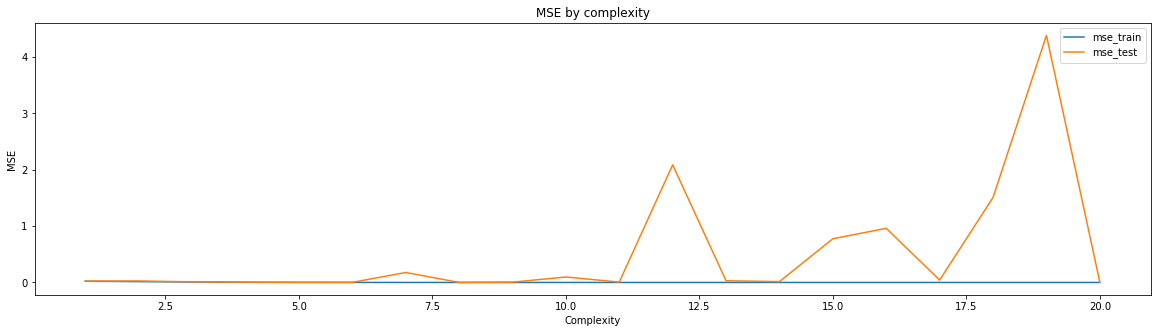

In [35]:
betas, xtx = simple_ols_run(num_points = 100, complexity = 20, noise = 1, plot_mse=True)

### Bootstrap

In [193]:
def bootstrap(x, y, num_samples = None):
    
    if num_samples == None:
        num_samples = x.shape[0]
        
    mse_list = np.zeros(num_samples)
    
    for i in range(num_samples):
        bootstrap_picks_x, bootstrap_picks_y  = resample(x,y, n_samples = num_samples)
        
        betas, xtx = simple_ols_run(bootstrap_picks_x, bootstrap_picks_y, complexity = 20, noise = 1)
        
        
x = (np.random.uniform(0, 1, 100))
y = (np.random.uniform(0, 1, 100))
bootstrap(x,y)


0
5.840388935134832e-08
1
2.777819221153059e-07
2
1.0982788663901769e-08
3
1.6855979967975725e-08
4
1.38835015072649e-07
5
4.280275144917887e-08
6
3.5033534467200727e-09
7
2.9220734495797145e-08
8
1.0347568626862092e-09
9
2.078296802571108e-07
10
3.503648985613462e-09
11
8.970672113156481e-10
12
1.6306951230793455e-08
13
2.3591073764372135e-07
14
1.804930861459523e-11
15
4.594287607834515e-09
16
1.4135751152881104e-08
17
1.5096170293281692e-11
18
6.549875298538043e-10
19
3.876471269369456e-12
20
1.334347382625588e-08
21
1.9406937297426877e-08
22
5.64548194567666e-09
23
1.4169507105453288e-10
24
8.68332012847699e-09
25
3.366243723338041e-08
26
1.298026511775864e-10
27
8.746462655505642e-10
28
4.740456054452651e-10
29
1.1952078970234392e-09
30
8.483602770239727e-10
31
5.2821225384945736e-12
32
2.6503203542201357e-10
33
1.5539667481245205e-08
34
2.2090728835572692e-08
35
1.7609098773408447e-09
36
4.2105287129039414e-07
37
1.374331713616227e-10
38


KeyboardInterrupt: 